In [3]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from poirot.spectrum import specparam_xr, specparam_attributes
import xarray as xr
import pandas as pd
from fooof import FOOOF, FOOOFGroup
import numpy as np
import seaborn as sb

import seaborn.objects as so
import matplotlib.pyplot as plt

sb.set_style("whitegrid")


def tee(df):
    display(df)
    return df


da = xr.open_dataarray("../data/output/LEMON_power.nc")
da.close()


stacked_columns = ["sub", "roi_names"]

fg = FOOOFGroup(
    peak_width_limits=[2, 8],
    min_peak_height=0.1,
    max_n_peaks=6,
)

freq_range = [2, 48]

df = da.isel(sub=slice(0, 1)).pipe(
    specparam_attributes,
    stacked_cols=["sub", "roi_names"],
    fg=fg,
    freq_range=freq_range,
)
# xs = da.stack(point=stacked_columns).transpose("point", "freqs")
display(df)


Running FOOOFGroup: 100%|██████████| 68/68 [00:02<00:00, 29.05it/s]


,sub,roi_names,regions,Y_OH_OL,CF,PW,BW,offset,exponent,error,r_squared
0,sub-032311,bankssts L,temporal,Y_H,10.958251,0.696652,2.704593,-16.362616,2.018266,0.041289,0.993794
1,sub-032311,bankssts L,temporal,Y_H,15.347680,0.574713,4.156081,-16.362616,2.018266,0.041289,0.993794
2,sub-032311,bankssts L,temporal,Y_H,21.435266,0.556007,5.894428,-16.362616,2.018266,0.041289,0.993794
3,sub-032311,bankssts L,temporal,Y_H,31.267951,0.291476,8.000000,-16.362616,2.018266,0.041289,0.993794
4,sub-032311,bankssts R,temporal,Y_H,10.842370,0.711575,2.000000,-16.443166,1.865295,0.035026,0.994270
...,...,...,...,...,...,...,...,...,...,...,...
252,sub-032311,transversetemporal R,temporal,Y_H,10.882840,0.839734,2.000000,-17.040148,1.876642,0.032510,0.994433
253,sub-032311,transversetemporal R,temporal,Y_H,17.453491,0.419934,8.000000,-17.040148,1.876642,0.032510,0.994433
254,sub-032311,transversetemporal R,temporal,Y_H,22.056794,0.678667,2.375941,-17.040148,1.876642,0.032510,0.994433
255,sub-032311,transversetemporal R,temporal,Y_H,29.106190,0.276412,8.000000,-17.040148,1.876642,0.032510,0.994433


In [11]:
df_regions = (  # have a small dataframne to work with
    da.groupby("regions")
    .mean(dim="roi_names")
    .pipe(
        specparam_attributes,
        stacked_cols=["sub", "regions"],
        fg=fg,
        freq_range=freq_range,
    )
)

Running FOOOFGroup: 100%|██████████| 895/895 [00:03<00:00, 287.13it/s]


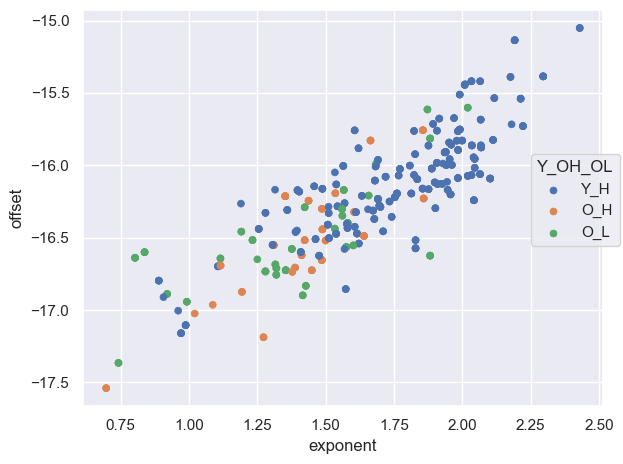

In [12]:
g = (
    df_regions.pipe(lambda x: x.loc[x["regions"] == "occipital"])
    .pipe(so.Plot, x="exponent", y="offset", color="Y_OH_OL")
    .add(so.Dot(pointsize=5))
)
g.show()


In [13]:
df_rois = da.pipe(  # have a small dataframne to work with
    specparam_attributes,
    stacked_cols=["sub", "roi_names"],
    fg=fg,
    freq_range=freq_range,
)


Running FOOOFGroup: 100%|██████████| 12172/12172 [01:53<00:00, 107.64it/s]


In [20]:
# store data as hdf5
storedata = pd.HDFStore(
    "../data/output/computed_specparam.hdf5", key="df_rois")
storedata.put("df_rois", df_rois)
storedata.close()


In [21]:
data = pd.read_hdf("../data/output/computed_specparam.hdf5")
df_rois = data["df_rois"]

ValueError: key must be provided when HDF5 file contains multiple datasets.

In [59]:
l = (
    df_rois.pipe(lambda x: x.loc[x["regions"] == "occipital"])
    .groupby(["sub", "Y_OH_OL"])
    .mean("roi_names")
)
display(l)

,,CF,PW,BW,offset,exponent,error,r_squared
sub,Y_OH_OL,,,,,,,
sub-032301,O_L,19.480011,0.653625,6.375499,-16.479457,1.352531,0.055087,0.983984
sub-032302,Y_H,13.202758,0.773164,7.364921,-16.070935,1.530434,0.102452,0.962428
sub-032303,O_L,17.128645,0.731002,6.632625,-16.399625,1.678129,0.065154,0.986999
sub-032304,Y_H,15.273876,0.643072,6.413764,-15.073657,2.474455,0.055789,0.993748
sub-032305,O_L,18.146735,0.588595,6.489327,-16.746508,1.362440,0.051011,0.983851
...,...,...,...,...,...,...,...,...
sub-032522,Y_H,18.930054,0.818617,6.894420,-15.961565,2.029809,0.072588,0.986786
sub-032523,Y_H,19.343473,0.234357,6.915465,-16.116192,2.015886,0.035349,0.993088
sub-032524,Y_H,18.015125,0.377938,6.106548,-16.490518,1.571052,0.048792,0.986882


In [3]:
color_dict = dict(
    {
        "Y_H": "red",
        "O_H": "blue",
        "O_L": "orange",
    }
)
# f, ax = plt.subplots()
f = plt.figure()
h = (
    df_rois.pipe(lambda x: x.loc[x["regions"] == "occipital"])
    .groupby(["sub", "Y_OH_OL"])
    .mean("roi_names")
    .pipe(so.Plot, x="exponent", y="offset", color="Y_OH_OL")
    .facet("Y_OH_OL")
    .add(so.Dot(pointsize=5))
)

h.on(f)

NameError: name 'df_rois' is not defined

<Figure size 640x480 with 0 Axes>